# Robust Identification of Investor Beliefs

by [Xiaohong Chen](https://economics.yale.edu/people/faculty/xiaohong-chen), [Lars Peter Hansen](http://larspeterhansen.org/) and [Peter G. Hansen](https://mitsloan.mit.edu/phd/students/peter-hansen).

The latest draft of the paper can be found [here](http://larspeterhansen.org/research/papers/).

Notebook by: Han Xu, Zhenhuan Xie

## 1. Overview

This notebook provides source code and explanations for how we solve the dynamic problem in Section 5. It also provides source code for the tables in Section 6. 

## 2. Intertemporal Divergence

Recall Problem 5.4 in the paper:

\begin{equation}
\mu = \min_{N_1\in \mathcal{N}} \mathbb{E}\left(N_1\left[g(X_1)+\xi\log N_1 + v_1\right]\mid \mathfrak{I}_0\right) - v_0
\end{equation}
subject to constraints:
\begin{equation}
\mathbb{E}\left[N_1 f(X_1)\mid\mathfrak{I}_0\right] = 0
\end{equation}

By Proposition 5.6, this problem can be solved by finding the solution to:

\begin{equation}
\epsilon = \min_{\lambda_0}\mathbb E \left(\exp \left[-\frac{1}{\xi}g(X_1)+\lambda_0\cdot f(X_1)\right]\left( \frac{e_1}{e_0}\right) \mid \mathfrak{I}_0\right)
\end{equation}

where
\begin{align*}
\mu &= -\xi \log \epsilon,\\
v_0 &= -\xi \log e_0.
\end{align*}

The implied solution for the probablity distortion is:

\begin{equation}
N_1^* = \frac{\exp \left[-\frac{1}{\xi}g(X_1)+\lambda^*_0(Z_0)\cdot f(X_1)\right]e_1^*}{\epsilon^*e_0^*}
\end{equation}

where $\lambda^*_0$ is the optimizing choice for $\lambda_0$ and $\left(\epsilon^*,e_0^*\right)$ are selected to that the resulting $\sf Q$ implies that the process is stochastically stable. The conditional expectation implied by the bound is

\begin{equation}
\mathbb{E}\left[N_1^*g(X_1)\mid \mathfrak{I}_0\right]
\end{equation}

which in turn implies a bound on the unconditional expectation equal to

\begin{equation}
\int \mathbb{E}\left[N_1^*g(X_1)\mid\mathfrak{I}_0\right]d \sf Q_0^*
\end{equation}

The implied relative entropy is

\begin{equation}
\int \mathbb{E}\left(N_1^*\log N_1^*\mid \mathfrak{I}_0\right)d \sf Q_0^*
\end{equation}

## 3. Code Implementation

In [1]:
# Load packages
import time
from utilities import *
from plotting_module import *

### 3.1 Data
The file “UnitaryData.csv” contains the following variables:

- The first four columns contain Euler equation errors from the unitary risk aversion model corresponding to the 3-month T-bill rate, the market excess return, the SMB excess return, and the HML excess return respectively. Under a feasible belief distortion, all four of these variables should have expectation zero (conditional or unconditional).


- The column “d.p” contains the dividend-price ratio for the CRSP value weighted index, computed at the start of the return period. Hence functions of d.p[i] (i.e. quantile indicator functions) are valid instruments for the returns in row i.


- The final column “log.RW” contains values of the logarithmic return on wealth. This is the random variable who’s expectation we are intersted in bounding.

All returns are quarterly and inflation adjusted.

In [2]:
# Load data
data = pd.read_csv('UnitaryData.csv')
# Show statistics of the data
data.describe()

,Rf,Rm-Rf,SMB,HML,d.p,log.RW
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,-0.010974,0.010974,0.004992,0.009498,0.029250,0.018864
std,0.086116,0.086116,0.052512,0.058218,0.010055,0.084452
min,-0.186245,-0.356102,-0.139624,-0.269700,0.010571,-0.312496
25%,-0.063218,-0.029274,-0.026004,-0.024469,0.020545,-0.021638
50%,-0.028582,0.028582,0.000834,0.008563,0.029106,0.031677
75%,0.029274,0.063218,0.035165,0.036895,0.036495,0.069903
max,0.356102,0.186245,0.169266,0.234932,0.058402,0.210429


We first compute the terciles of dividend-price ratio and form indicator functions of these terciles. Then we multiply the first four columns by the indicator functions to form a 12-dimensional $f$. The last column log.RW is our $g$.

### 3.2 Computational Strategy

In our application, we just have 3 distinct states, so we can represent the function $e(\cdot)$ as a 3-dimensional vector. Additionally, we are free to impose the normalization $e_1=1$. We can solve the dual problem numerically by something analogous to value function iteration for $e=(1,e_2,e_3)$. Here is the iteration scheme:

1\. Guess $e=(1,1,1)$.

2\. For $k \in \{1,2,3\}$, solve
\begin{equation}
v_k = \min_{\lambda_0} \hat{\mathbb{E}}\left(\exp \left[-\frac{1}{\xi}g(X_1) + \lambda_0f(X_1)\right]e(X_1)\mid \text{state today = } k\right)
\end{equation}

3\. Store
\begin{align*}
\hat{e} &= v/v_1 \\
\hat{\epsilon} &= v_1 \\
\text{error} &= \|\hat{e}-e\|
\end{align*}

4\. Set $e = \hat{e}$.

5\. Iterate steps 2-4 until error is arbitrarily close to zero.

Once we have (approximately) stationary values for $\epsilon$ and $e$, we can form the conditional belief distortion
\begin{equation}
N_1 = \frac{1}{\epsilon} \exp \left[-\frac{1}{\xi}g(X_1)+\lambda_0 \cdot f(X_1)\right]\frac{e_1}{e_0}
\end{equation}

To obtain the unconditional relative entropy, we need to average across states using the implied stationary distribution coming from the distorted probabilities. Define a $3\times 3$ matrix $\tilde{P}$ by 
$$
\tilde{P}_{i,j} = \hat{\mathbb{E}}\left[N_1 \mathcal{1}\left(\text{state tomorrow = j}\right)\mid \text{state today = i}\right]
$$

We should have that $\tilde{P}$ is a transition probability matrix, so $\tilde{P}\mathcal{1}=\mathcal{1}$. Next, solve for the stationary distribution $\pi\in \mathbb{R}^3$ as the dominant left eigenvector of $\tilde{P}$, i.e.
\begin{equation}
\tilde{\pi}^\prime \tilde{P} = \tilde{\pi}^\prime
\end{equation}

Then, the unconditional relative entropy can be computed as
\begin{equation}
\text{RE}(\xi) = \sum_{k=1}^{3}\hat{\mathbb{E}}\left[N_1\log N_1 \mid \text{state today = k}\right]\cdot \tilde{\pi}_k
\end{equation}

In [15]:
# Count time
time_start = time.time() 

# Initialize the solver
solver = InterDivConstraint(tol=1e-9,max_iter=1000)

# Define g(X) = log Rw
solver.g = solver.log_Rw

# Find ξ that corresponds to 120% min RE
x_min_RE = 1.2
# ξ_lower = solver.find_ξ(x_min_RE=x_min_RE,lower=True,tol=1e-7,max_iter=100)
# ξ_upper = solver.find_ξ(x_min_RE=x_min_RE,lower=False,tol=1e-7,max_iter=100)
ξ_lower = 0.14301961660385132
ξ_upper = 0.14917802810668945
# ξ_lower = 100.
# ξ_upper = 100.

# Solve models with the chosen ξ
result_lower = solver.iterate(ξ_lower,lower=True)
result_upper = solver.iterate(ξ_upper,lower=False)

# Print out the time spent
time_spent = round(time.time()-time_start,4)

### 3.3 Results

In [16]:
# Print iteration information
print("--- Iteration Ends ---")
print("%sx min RE" % x_min_RE)
print("Time spent: %s seconds ---" % (time_spent))

# Print converged parameter results
print("\n")
print("--- Converged values for the lower bound problem ---")
print("ϵ: %s" % result_lower['ϵ'])
print("e: %s" % result_lower['e'])
print("λ: %s" % result_lower['λ'])
print("μ: %s" % result_lower['μ'])

print(" ")
print("--- Converged values for the upper bound problem ---")
print("ϵ: %s" % result_upper['ϵ'])
print("e: %s" % result_upper['e'])
print("λ: %s" % result_upper['λ'])
print("μ: %s" % result_upper['μ'])

# Print transition probability matrix under the original empirical probability
print("\n")
print("--- Transition Probability Matrix (Original) ---")
print(result_lower['P'])

# Print transition probability matrix under distorted probability, lower bound
print(" ")
print("--- Transition Probability Matrix (Distorted, lower bound problem) ---")
print(result_lower['P_tilde'])

# Print transition probability matrix under distorted probability, upper bound
print(" ")
print("--- Transition Probability Matrix (Distorted, upper bound problem) ---")
print(result_upper['P_tilde'])


# Print stationary distribution under the original empirical probability
print("\n")
print("--- Stationary Distribution (Original) ---")
print(result_lower['π'])

# Print stationary distribution under distorted probability, lower bound
print(" ")
print("--- Stationary Distribution (Distorted, lower bound problem) ---")
print(result_lower['π_tilde'])

# Print stationary distribution under distorted probability, upper bound
print(" ")
print("--- Stationary Distribution (Distorted, upper bound problem) ---")
print(result_upper['π_tilde'])

# Print relative entropy
print("\n")
print("--- Relative Entropy (lower bound problem) ---")
print("E[NlogN|state 1] = %s " % result_lower['RE_cond'][0])
print("E[NlogN|state 2] = %s " % result_lower['RE_cond'][1])
print("E[NlogN|state 3] = %s " % result_lower['RE_cond'][2])
print("E[NlogN]         = %s " % result_lower['RE'])

# Print relative entropy
print(" ")
print("--- Relative Entropy (Upper bound problem) ---")
print("E[NlogN|state 1] = %s " % result_upper['RE_cond'][0])
print("E[NlogN|state 2] = %s " % result_upper['RE_cond'][1])
print("E[NlogN|state 3] = %s " % result_upper['RE_cond'][2])
print("E[NlogN]         = %s " % result_upper['RE'])

# Print conditional moment & bounds
print("\n")
print("--- Moment (Original, annualized, %) ---")
print("E[g(X)|state 1]  = %s " % (result_lower['moment_cond'][0]*400))
print("E[g(X)|state 2]  = %s " % (result_lower['moment_cond'][1]*400))
print("E[g(X)|state 3]  = %s " % (result_lower['moment_cond'][2]*400))
print("E[g(X)]  = %s " % (result_lower['moment']*400))
print(" ")
print("--- Moment (Lower bound, annualized, %) ---")
print("E[Ng(X)|state 1] = %s " % (result_lower['moment_bound_cond'][0]*400))
print("E[Ng(X)|state 2] = %s " % (result_lower['moment_bound_cond'][1]*400))
print("E[Ng(X)|state 3] = %s " % (result_lower['moment_bound_cond'][2]*400))
print("E[Ng(X)] = %s " % (result_lower['moment_bound']*400))
print(" ")
print("--- Moment (Upper bound, annualized, %) ---")
print("E[Ng(X)|state 1] = %s " % (result_upper['moment_bound_cond'][0]*400))
print("E[Ng(X)|state 2] = %s " % (result_upper['moment_bound_cond'][1]*400))
print("E[Ng(X)|state 3] = %s " % (result_upper['moment_bound_cond'][2]*400))
print("E[Ng(X)] = %s " % (result_upper['moment_bound']*400))

--- Iteration Ends ---
1.2x min RE
Time spent: 0.6535 seconds ---


--- Converged values for the lower bound problem ---
ϵ: 0.9375400619553619
e: [1.         0.37118583 0.13034919]
λ: [-1.6645899   3.6645899  -0.38953434 -0.87010901 -1.33790776  3.33790776
  0.73294648 -6.53554462 -0.25831094  2.25831094 -3.77016074 -7.08343564]
μ: 0.009224163057991801
 
--- Converged values for the upper bound problem ---
ϵ: 1.0176687033922105
e: [1.         0.51956861 0.29340318]
λ: [ 4.81010371 -2.81010371 -0.33854612 -0.44087497  4.96968764 -2.96968764
  0.60594578 -5.44145381  6.47500395 -4.47500395 -3.21397612 -8.72944529]
μ: -0.0026127676013306127


--- Transition Probability Matrix (Original) ---
[[0.96341463 0.03658537 0.        ]
 [0.04878049 0.87804878 0.07317073]
 [0.         0.08433735 0.91566265]]
 
--- Transition Probability Matrix (Distorted, lower bound problem) ---
[[0.98490796 0.01509204 0.        ]
 [0.09885648 0.87225348 0.02889004]
 [0.         0.19434385 0.80565615]]
 
--- Transi

### 3.4 Plots

In [ ]:
time_start = time.time() 
entropy_moment_bounds()
print("Time spent: %s seconds ---" % (round(time.time()-time_start,4)))

## 4. Tables and plots in Section 6

In [5]:
# Use 20% higher than min RE
x_min_RE = 1.2

# Case 1: g(X) = log Rw
solver_1 = InterDivConstraint(tol=1e-9,max_iter=1000)
solver_1.g = solver_1.log_Rw
# ξ_1_lower = solver_1.find_ξ(x_min_RE=x_min_RE,lower=True,tol=1e-7,max_iter=100)
# ξ_1_upper = solver_1.find_ξ(x_min_RE=x_min_RE,lower=False,tol=1e-7,max_iter=100)
ξ_1_lower = 0.14301961660385132
ξ_1_upper = 0.14917802810668945
result_1_lower = solver_1.iterate(ξ_1_lower,lower=True)
result_1_upper = solver_1.iterate(ξ_1_upper,lower=False)
result_1_min = solver_1.iterate(100.,lower=True)

# Case 2: g(X) = Rw
solver_2 = InterDivConstraint(tol=1e-9,max_iter=1000)
solver_2.g = np.exp(solver_2.log_Rw)
# ξ_2_lower = solver_2.find_ξ(x_min_RE=x_min_RE,lower=True,tol=1e-7,max_iter=100)
# ξ_2_upper = solver_2.find_ξ(x_min_RE=x_min_RE,lower=False,tol=1e-7,max_iter=100)
ξ_2_lower = 0.1632009744644165
ξ_2_upper = 0.17359530925750732
result_2_lower = solver_2.iterate(ξ_2_lower,lower=True)
result_2_upper = solver_2.iterate(ξ_2_upper,lower=False)
result_2_min = solver_2.iterate(1000.,lower=True)

# Case 3: g(X) = Rw/Rf
solver_3 = InterDivConstraint(tol=1e-9,max_iter=1000)
solver_3.g = 1./(solver_3.X[:,0]+1.)
# ξ_3_lower = solver_3.find_ξ(x_min_RE=x_min_RE,lower=True,tol=1e-7,max_iter=100)
# ξ_3_upper = solver_3.find_ξ(x_min_RE=x_min_RE,lower=False,tol=1e-7,max_iter=100)
ξ_3_lower = 0.08675366640090942
ξ_3_upper = 0.09542280435562134
result_3_lower = solver_3.iterate(ξ_3_lower,lower=True)
result_3_upper = solver_3.iterate(ξ_3_upper,lower=False)
result_3_min = solver_3.iterate(100.,lower=True)

In [6]:
print('Table 1: Probabilities')
print('')
print('Transition matrix and stationary distribution:')
print("")

print("--- empirical ---")
print('    ',np.round(result_1_min['P'][0],2))
print('P = ',np.round(result_1_min['P'][1],2))
print('    ',np.round(result_1_min['P'][2],2))
print('')
print('π = ',np.round(result_1_min['π'],2))
print('\n')

print("--- min rel entropy ---")
print('    ',np.round(result_1_min['P_tilde'][0],2))
print('P = ',np.round(result_1_min['P_tilde'][1],2))
print('    ',np.round(result_1_min['P_tilde'][2],2))
print('')
print('π = ',np.round(result_1_min['π_tilde'],2))
print('\n')

print("--- %s percent min rel entropy, lower bound ---" % (int(x_min_RE*100)))
print('    ',np.round(result_1_lower['P_tilde'][0],2))
print('P = ',np.round(result_1_lower['P_tilde'][1],2))
print('    ',np.round(result_1_lower['P_tilde'][2],2))
print('')
print('π = ',np.round(result_1_lower['π_tilde'],2))
print('\n')

print("--- %s percent min rel entropy, upper bound ---" % (int(x_min_RE*100)))
print('    ',np.round(result_1_upper['P_tilde'][0],2))
print('P = ',np.round(result_1_upper['P_tilde'][1],2))
print('    ',np.round(result_1_upper['P_tilde'][2],2))
print('')
print('π = ',np.round(result_1_upper['π_tilde'],2))

Table 1: Probabilities

Transition matrix and stationary distribution:

--- empirical ---
     [0.96 0.04 0.  ]
P =  [0.05 0.88 0.07]
     [0.   0.08 0.92]

π =  [0.42 0.31 0.27]


--- min rel entropy ---
     [0.98 0.02 0.  ]
P =  [0.08 0.88 0.04]
     [0.   0.17 0.83]

π =  [0.76 0.2  0.04]


--- 120 percent min rel entropy, lower bound ---
     [0.98 0.02 0.  ]
P =  [0.1  0.87 0.03]
     [0.   0.19 0.81]

π =  [0.85 0.13 0.02]


--- 120 percent min rel entropy, upper bound ---
     [0.97 0.03 0.  ]
P =  [0.07 0.88 0.04]
     [0.   0.15 0.85]

π =  [0.65 0.27 0.08]


In [7]:
print('Table 2: Expected market return')
print('--------------------------------------------------------------------')
print('conditioning    empirical    min entropy imputed    Rw/Rf imputed')
print('                 average       (lower, upper)       (lower,upper)')
print('--------------------------------------------------------------------')
print('low D/P           %s              %s                %s' \
      % (np.round(np.log(result_2_min['moment_cond'][0])*400,2),np.round(np.log(result_2_min['moment_bound_cond'][0])*400,2),np.round(np.log(result_3_min['moment_bound_cond'][0])*400,2)))
print('                                (%s,%s)         (%s,%s)' \
      % (np.round(np.log(result_2_lower['moment_bound_cond'][0])*400,2),np.round(np.log(result_2_upper['moment_bound_cond'][0])*400,2),np.round(np.log(result_3_lower['moment_bound_cond'][0])*400,2),np.round(np.log(result_3_upper['moment_bound_cond'][0])*400,2)))
print('mid D/P           %s               %s                %s' \
      % (np.round(np.log(result_2_min['moment_cond'][1])*400,2),np.round(np.log(result_2_min['moment_bound_cond'][1])*400,2),np.round(np.log(result_3_min['moment_bound_cond'][1])*400,2)))
print('                                (%s,%s)         (%s,%s)' \
      % (np.round(np.log(result_2_lower['moment_bound_cond'][1])*400,2),np.round(np.log(result_2_upper['moment_bound_cond'][1])*400,2),np.round(np.log(result_3_lower['moment_bound_cond'][1])*400,2),np.round(np.log(result_3_upper['moment_bound_cond'][1])*400,2)))
print('high D/P          %s             %s                %s' \
      % (np.round(np.log(result_2_min['moment_cond'][2])*400,2),np.round(np.log(result_2_min['moment_bound_cond'][2])*400,2),np.round(np.log(result_3_min['moment_bound_cond'][2])*400,2)))
print('                                (%s,%s)         (%s,%s)' \
      % (np.round(np.log(result_2_lower['moment_bound_cond'][2])*400,2),np.round(np.log(result_2_upper['moment_bound_cond'][2])*400,2),np.round(np.log(result_3_lower['moment_bound_cond'][2])*400,2),np.round(np.log(result_3_upper['moment_bound_cond'][2])*400,2)))
print('none              %s              %s                %s' \
      % (np.round(np.log(result_2_min['moment'])*400,2),np.round(np.log(result_2_min['moment_bound'])*400,2),np.round(np.log(result_3_min['moment_bound'])*400,2)))
print('                                (%s,%s)         (%s,%s)' \
      % (np.round(np.log(result_2_lower['moment_bound'])*400,2),np.round(np.log(result_2_upper['moment_bound'])*400,2),np.round(np.log(result_3_lower['moment_bound'])*400,2),np.round(np.log(result_3_upper['moment_bound'])*400,2)))
print('--------------------------------------------------------------------')
print('note: the numbers in the parentheses impose a relative entropy')
print('      constraint that is %s percent higher than the minimum.' % (int(x_min_RE*100-100)))

Table 2: Expected market return
--------------------------------------------------------------------
conditioning    empirical    min entropy imputed    Rw/Rf imputed
                 average       (lower, upper)       (lower,upper)
--------------------------------------------------------------------
low D/P           6.54              3.67                3.0
                                (2.91,4.49)         (2.64,3.37)
mid D/P           4.7               3.81                2.22
                                (3.53,4.11)         (1.85,2.68)
high D/P          15.41             6.58                3.47
                                (6.12,7.05)         (2.88,4.12)
none              8.94              3.82                2.86
                                (3.07,4.59)         (2.46,3.28)
--------------------------------------------------------------------
note: the numbers in the parentheses impose a relative entropy
      constraint that is 20 percent higher than the minimum.


In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
    
# Find ξs that correspond to 0-25 percent higher min RE
# ξs_lower = []
# ξs_upper = []
# for i in range(0,26):
#     if i == 0:
#         ξs_lower.append(100)
#         ξs_upper.append(100)
#     else:
#         ξ_lower_temp = solver_1.find_ξ(x_min_RE=(i+100)/100,lower=True, tol=1e-7,max_iter=100)
#         ξ_upper_temp = solver_1.find_ξ(x_min_RE=(i+100)/100,lower=False,tol=1e-7,max_iter=100)
#         ξs_lower.append(ξ_lower_temp)
#         ξs_upper.append(ξ_upper_temp)

time_start = time.time()
result_1_lower_list = []
result_1_upper_list = []
for i in range(0,26):
    result_1_lower_list.append(solver_1.iterate(ξs_lower[i],lower=True))
    result_1_upper_list.append(solver_1.iterate(ξs_upper[i],lower=False))

def f(percent):
    box_chart(result_1_min,result_1_lower_list[percent],result_1_upper_list[percent])
    
interact(f, percent=widgets.IntSlider(min=0, max=25, step=1, value=20));
print("Time spent: %s seconds ---" % (round(time.time()-time_start,4)))

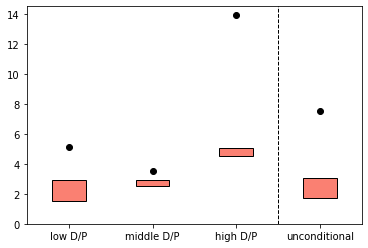

In [8]:
# box_20%
box_chart(result_1_min,result_1_lower,result_1_upper,True,dpi=1200)